# TrafficSignLocalization
We apply transfer learning to a Convolutional Neural Network (CNN) with PyTorch to localize and classify distinct classes of traffic signs in individual images of the Belgium Traffic Sign Classification Benchmark Dataset (https://btsd.ethz.ch/shareddata/).

In [1]:
import os
import random

import pandas as pd

import numpy as np
np.random.seed(42)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import torchvision.ops.boxes as bops
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [2]:
# Check if CUDA is available and set variable 'device' accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load the dataset
Each of the 62 classes has its own directory containing the corresponding images and a 
text file with the metadata (semicolon as field separator).

In [3]:
noClasses = 62

# Load metadata into pandas DataFrame
dataDir='BelgiumTSC' # Needs to be adjusted depending on where data is stored
testDir = os.path.join(dataDir, 'Testing')
trainDir = os.path.join(dataDir, 'Training')

def loadMetadata(ddir):
    for idx in tqdm(range(noClasses), desc="Loading metadata..."):
        csvDir = os.path.join(ddir, '{:05d}'.format(idx))
        csvFile = os.path.join(csvDir, 'GT-{:05d}.csv'.format(idx))
        
        dfT = pd.read_csv(csvFile, sep=';')
        dfT['Filepath'] = dfT['Filename'].apply(lambda x:  os.path.join(csvDir, x))
        
        if idx == 0:
            df = dfT.copy(deep=True)
        else:
            df = df.append(dfT, ignore_index=True)

    return df

dfTV = loadMetadata(testDir)
dfTrain = loadMetadata(trainDir)
dfTrain

Loading metadata...: 100%|██████████| 62/62 [00:00<00:00, 116.11it/s]


,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Filepath
0,01153_00000.ppm,141,142,12,12,128,130,0,BelgiumTSC\Training\00000\01153_00000.ppm
1,01153_00001.ppm,120,123,10,10,109,113,0,BelgiumTSC\Training\00000\01153_00001.ppm
2,01153_00002.ppm,105,107,9,9,96,98,0,BelgiumTSC\Training\00000\01153_00002.ppm
3,01160_00000.ppm,94,105,8,9,86,95,0,BelgiumTSC\Training\00000\01160_00000.ppm
4,01160_00001.ppm,128,139,11,12,117,127,0,BelgiumTSC\Training\00000\01160_00001.ppm
...,...,...,...,...,...,...,...,...,...
4586,01957_00001.ppm,75,74,6,6,69,67,61,BelgiumTSC\Training\00061\01957_00001.ppm
4587,01957_00002.ppm,55,53,5,5,49,48,61,BelgiumTSC\Training\00061\01957_00002.ppm
4588,01959_00000.ppm,111,67,9,6,102,61,61,BelgiumTSC\Training\00061\01959_00000.ppm
4589,01959_00001.ppm,39,39,5,5,34,34,61,BelgiumTSC\Training\00061\01959_00001.ppm


In [4]:
def plot_class_frequencies(df):
    classFrequencies = df['ClassId'].value_counts()
    classFrequencies.sort_index(inplace=True)

    print("Number of classes: ", noClasses)

    plt.clf()
    plt.figure(figsize=(15,4))
    x = classFrequencies.index.tolist()
    y = classFrequencies.tolist()
    plt.bar(x, y)

    up = max(y) * .03
    for xi, yi, la in zip(*[x, y, list(map(str, y))]):
        plt.text(xi-len(y)*0.01, yi+max(y)*.01, la)

    plt.xlabel("Class ID")
    plt.ylabel("Class frequency")
    plt.show()

The dataset has unbalanced class frequencies and the number of images per class is often very small. Data augmentation (e.g., random translation and rotation, adding noise, ...) to create a larger image set would be one way to improve the performance of the deep-learning model. This step is left for future work.

Number of classes:  62


<Figure size 432x288 with 0 Axes>

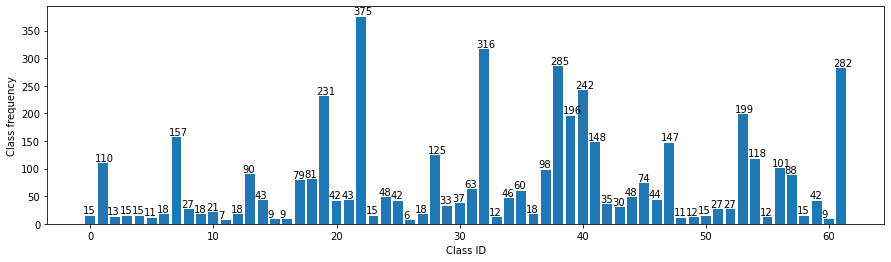

In [5]:
plot_class_frequencies(dfTrain)

In [6]:
# Use ImageNet std and mean to normalize the RGB channels
rgbMean = np.array([0.485, 0.456, 0.406])
rgbStd = np.array([0.229, 0.224, 0.225])

In [7]:
class LoadDataset(Dataset):
    """Class to load the  Belgium Traffic Sign Classification Benchmark dataset"""

    def __init__(self, df, train=True):
        """
        Args:
            df (DataFrame): Pandas DataFrame
        """
        self.df = df
        self.train = train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image using the Python Image Library (PIL)
        imgName = self.df.loc[idx, 'Filepath']
        # The PNG images have 4 Channels, RGB+alpha/transparency
        img = Image.open(imgName).convert('RGB')

        # Region of interest
        x1, y1, x2, y2 = self.df.loc[idx, ['Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2']].astype(int)

        mask = np.zeros(img.size).T
        mask[x1:x2, y1:y2] = 1.
        mask = Image.fromarray(mask)

        # Apply transform
        img, mask, bbox = self.transform(img, mask)
        
        truth = self.df.loc[idx, 'ClassId']  
        
        return img, truth, bbox
    
    def transform(self, img, mask):
        # Transform to tensor
        img = TF.to_tensor(img)
        mask = TF.to_tensor(mask)
        
        # Resize
        resize = transforms.Resize(size=(200, 200))
        img = resize(img)
        mask = resize(mask)
        
        if self.train:
            # Crop randomly
            i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(190, 190))
            #img = TF.crop(img, i, j, h, w)
            #mask = TF.crop(mask, i, j, h, w)
        
            # Rotate randomly
            a, b = -10, 10
            ang = (b - a)*np.random.rand() + a
            #img = TF.rotate(img, ang)
            #mask = TF.rotate(mask, ang)
        
        # Normalize RGB channels
        norm = transforms.Normalize(mean=rgbMean, std=rgbStd)
        img = norm(img)
        
        bbox = self.extract_bbox( Image.fromarray(mask.numpy()[0]) )
        
        return img, mask, bbox
    
    def extract_bbox(self, mask):
        # Given a mask, compute the four unique coordinates of the bounding box
        hi = np.where(np.any(mask, axis=0))[0] # horizontal indicies
        vi = np.where(np.any(mask, axis=1))[0] # vertical indicies

        x1, x2 = hi[[0, -1]]
        y1, y2 = vi[[0, -1]]

        x2 += 1
        y2 += 1

        bbox = np.array([y1, x1, y2, x2], dtype=np.int32)

        return bbox

### Extract dataset for validation

In [8]:
num = len(dfTV)
indices = list(range(num))
np.random.shuffle(indices)

split = int(np.floor(0.57 * num))
idxTest, idxValid = indices[split:], indices[:split]

dfValid = dfTV.iloc[idxValid].reset_index(drop=True)
dfTest = dfTV.iloc[idxTest].reset_index(drop=True)

ntot = len(dfTV)+len(dfTrain)
print('Training: \t{:.2f}% ({})'.format(len(dfTrain)/ntot*100., len(dfTrain)))
print('Validation: \t{:.2f}% ({})'.format(len(dfValid)/ntot*100., len(dfValid)))
print('Test: \t\t{:.2f}% ({})'.format(len(dfTest)/ntot*100., len(dfTest)))

Training: 	64.44% (4591)
Validation: 	20.27% (1444)
Test: 		15.30% (1090)


Number of classes:  62


<Figure size 432x288 with 0 Axes>

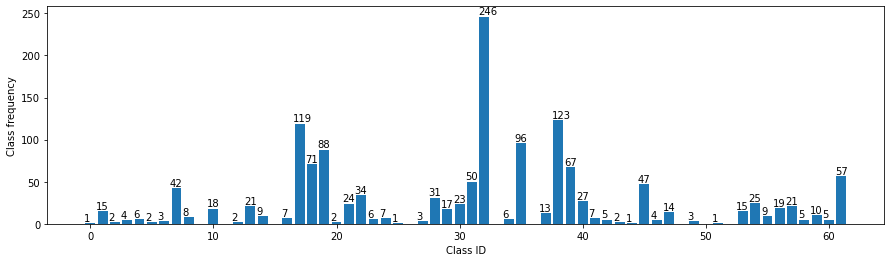

In [38]:
# Class frequencies of the validation dataset
plot_class_frequencies(dfValid)

In [9]:
dataTrain = LoadDataset(dfTrain, train=True)
dataValid = LoadDataset(dfValid, train=False)
dataTest = LoadDataset(dfTest, train=False) 

In [10]:
# Define number of subprocesses for data loading
numWorkers = 0

# Define how many samples per batch to load
batchSize = 32

# Create data loaders
loaderTrain = DataLoader(dataTrain, batch_size=batchSize,  num_workers=numWorkers, shuffle=True)
loaderValid = DataLoader(dataValid, batch_size=batchSize,  num_workers=numWorkers, shuffle=True)
loaderTest = DataLoader(dataTest, batch_size=batchSize,  num_workers=numWorkers)

In [11]:
# Helper function to reverse normalization, convert tensor and display the image
def imshow(img):
    img = img * rgbStd[:, None, None] + rgbMean[:, None, None]
    # Scale image to ignore expected imshow warning:
    # Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
    img = (img.numpy() * 255).astype(np.uint8)
    plt.imshow(np.transpose(img, (1, 2, 0))[:,:,0], cmap=plt.cm.gray)

In [12]:
# Helper function to extract a rectangular matplotlib patch for plotting
def extract_bpatch(bbox, color='green', ls='-'):
    bpatch = plt.Rectangle((bbox[1], bbox[0]), bbox[3]-bbox[1], bbox[2]-bbox[0], color=color, ls=ls, fill=False, lw=3)
    return bpatch

<Figure size 432x288 with 0 Axes>

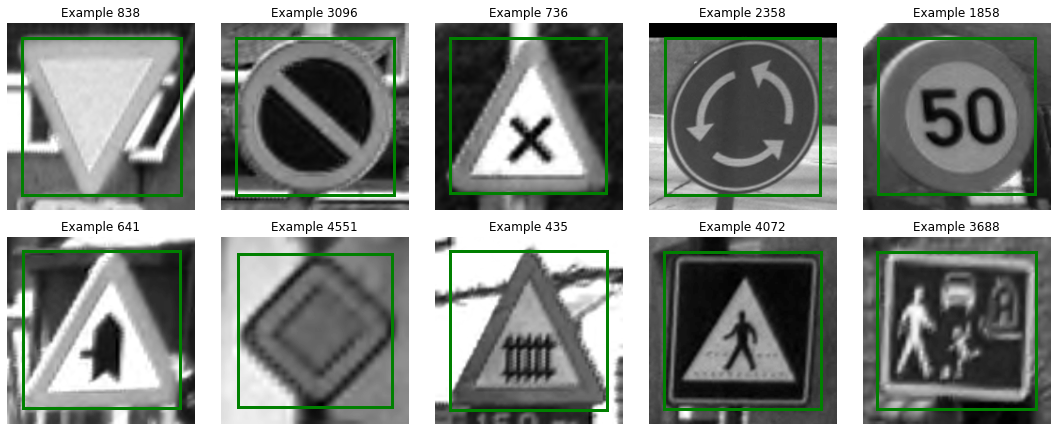

In [43]:
# Visualize random images from the training set. Transforms are already applied.
plt.clf()
plt.figure(figsize=(15,15))

for i in range(1,11):
    plt.subplot(5,5,i)
    idx = random.choice(range(len(dataTrain)))
    img, _, bbox = dataTrain[idx]
    bpatch = extract_bpatch(bbox)
    imshow(img)
    plt.gca().add_patch(bpatch)
    plt.title('Example {}'.format(idx))
    plt.axis('off')
    plt.tight_layout()

###  Transfer Learning

We use the architecture and pretrained weights of ResNet-18, which is a convolutional neural network that is 18 layers deep. This network skips training of a few layers by directly connecting non-adjacent layers, therby reducing the problem of vanishing/exploding gradients (meaning that the gradient becomes zero or too large). This is a common problem when simply using more and more layers in a deep neural network because an increase in the number of layers leads to an increase in error rate of the traing and test datasets.

We replace the fully connected layer at the end of the ResNet-18 and replace it with two final layers. One for image classification that connects to the 62 classes and one for the four bounding box coordinates.

In [14]:
class ModelBB(nn.Module):
    def __init__(self):
        super(ModelBB, self).__init__()
        model = torchvision.models.resnet18(pretrained=True)
        # The fully connected layer of ResNet-18 has 512 input and 1000 output features
        # Display architecture using e.g. model.eval())
        numFtrs = model.fc.in_features
        
        # Freeze pretrained model parameters
        for param in model.parameters():
            param.requires_grad = False
        
        # Add one free parameter to learn the weight between the two loss functions
        self.lossWeight = nn.Parameter(100.*torch.ones(1))
        
        # Dropout layer
        self.dropout = nn.Dropout(0.2)
        
        # We remove the fully connected layer and replace it with two final layers
        layers = list(model.children())[:-1]
        self.conv = nn.Sequential(*layers)
        # One for the the image classifier that connects to the 62 classes
        self.classifier = nn.Sequential(nn.BatchNorm1d(numFtrs), nn.Linear(numFtrs, noClasses))
        # One for the four bounding box coordinates
        self.bbox = nn.Sequential(nn.BatchNorm1d(numFtrs), nn.Linear(numFtrs, 4))
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        x = F.relu(x)    
        return self.classifier(x), self.bbox(x), self.lossWeight

In [15]:
model = ModelBB()
model.to(device)

ModelBB(
  (dropout): Dropout(p=0.2, inplace=False)
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1

### The loss functions

For the classification task, we use a Cross-Entropy loss function.

There are multiple ways to compute the loss for bounding box regression. We use a standard L1 Loss function (Least Absolute Deviations) to minimize the sum of all the absolute differences between the true value and the predicted value. Another approach is to compute the area of overlap between the true box and the target box and devide this number by the area of intersection. This is called Intersection over Union (IoU) and the reader is reffered to this publication for further details and comparissons (https://giou.stanford.edu/GIoU.pdf). However, we compute the IoUs and use the average IoU as a metric for visualization purposes.

In addition, we need to weight each class by its frequency to account for the imbalance (as shown above). On the other hand, the two loss functions need to be weighted against each other.

In [16]:
# The classes are weighted manually according to class frequencies
classFrequencies = dfTrain['ClassId'].value_counts()
classWeights = torch.tensor(classFrequencies.tolist(), dtype=torch.float32)
classWeights /= classWeights.sum()
classWeights = 1. / classWeights
classWeights /= classWeights.sum()
print (classWeights)

tensor([0.0011, 0.0013, 0.0014, 0.0014, 0.0017, 0.0017, 0.0020, 0.0020, 0.0025,
        0.0027, 0.0027, 0.0032, 0.0034, 0.0036, 0.0040, 0.0041, 0.0044, 0.0045,
        0.0049, 0.0051, 0.0054, 0.0063, 0.0067, 0.0083, 0.0083, 0.0087, 0.0091,
        0.0093, 0.0093, 0.0095, 0.0095, 0.0095, 0.0108, 0.0114, 0.0121, 0.0133,
        0.0148, 0.0148, 0.0148, 0.0190, 0.0222, 0.0222, 0.0222, 0.0222, 0.0222,
        0.0266, 0.0266, 0.0266, 0.0266, 0.0266, 0.0266, 0.0307, 0.0333, 0.0333,
        0.0333, 0.0363, 0.0363, 0.0444, 0.0444, 0.0444, 0.0571, 0.0666])


In [17]:
critClassifier = nn.CrossEntropyLoss(reduction='none')
critBbox = nn.L1Loss(reduction="none")
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Train the network

In [18]:
# Function to compute the loss and accuracies (total and individual classes)
def compNetPars(model, loader, noClasses):
    """
    noClasses (int): Number of classes
    strFlag (bool): If True, return string with detailed accuracies for each class
    """
    iouSet = 0.
    lossSet = 0.
    classCorrect = list(0. for i in range(noClasses))
    classTotal = list(0. for i in range(noClasses))
    
    # Iterate over data
    for idxBatch, (data, targetClass, targetBbox) in enumerate(loader):
        data = data.to(device)
        targetClass, targetBbox = targetClass.to(device), targetBbox.to(device)
        
        if model.training:
            # Clear gradients of optimized variables
            optimizer.zero_grad()
        
        # Forward pass: pass input to model and compute predicted output
        outClass, outBbox, lossWeight = model(data)
        lossClass = critClassifier(outClass, targetClass)
        lossClass = lossClass.sum() / classWeights[targetClass].sum() # Weighting
        
        lossBb = critBbox(outBbox, targetBbox).sum(1).sum()
        lossBb = lossBb.sum() / classWeights[targetClass].sum() # Weighting
        
        # Calculate total loss of the batch
        # Scale the loss of the bounding box by 1/lossWeight
        loss = lossClass + lossBb/lossWeight
        
        if model.training:
            # Backward pass: given the model parameters compute the gradients of the loss
            loss.backward()
            # Optimization step
            optimizer.step()
        
        # Add to set loss
        lossSet += loss.item()
        
        # Intersection over Union
        for tBox, oBox in zip(targetBbox, outBbox):
            iouSet += bops.box_iou(tBox[None, :], oBox[None, :]).item()
        
        # Convert output probabilities to predicted class
        _, pred = torch.max(outClass, 1)
        # Compare predictions to true label
        correctTensor = pred.eq(targetClass.data.view_as(pred))
        correct = correctTensor.numpy() if device == 'cuda' else correctTensor.cpu().numpy()
        
        # For each object class calculate set accuracy
        for i in range(len(targetClass)):
            label = targetClass.data[i]
            classCorrect[label] += correct[i].item()
            classTotal[label] += 1
    
    # Average loss
    lossSet = lossSet/len(loader.sampler)
    
    # Average IoU
    iouSet = iouSet/len(loader.sampler) * 100.
    
    # Overall Accuracy
    totAcc = 100. * np.sum(classCorrect) / np.sum(classTotal)
                        
    return classCorrect, classTotal, lossSet, totAcc, iouSet    

In [19]:
# Specify the number of epochs to train the model
nEpochs = 20

# To track validation loss changes
lossValidMin = np.Inf

# To track loss and accuracy for each epoch
lossAll, accAll, iouAll = [], [], []

for epoch in range(1, nEpochs+1):
    # Model training
    model.train()
    ccTrain, ctTrain, lossTrain, accTrain, iouTrain = compNetPars(model, loaderTrain, noClasses)
    
    # Model validation
    model.eval()
    ccValid, ctValid, lossValid, accValid, iouValid = compNetPars(model, loaderValid, noClasses)
    
    # Save the model if validation loss decreases
    if lossValid < lossValidMin:
        torch.save(model.state_dict(), 'model_tsc.pt')
        lossValidMin = lossValid
    
    # Model test
    ccTest, ctTest, lossTest, accTest, iouTest = compNetPars(model, loaderTest, noClasses)
    
    lossAll.append([lossTrain, lossValid, lossTest])
    accAll.append([accTrain, accValid, accTest])
    iouAll.append([iouTrain, iouValid, iouTest])
    
    if epoch == 1:
        print('Epoch \tTraining \t\t\tValidation \t\t\tTest \n')
        print(' \tLoss / Accuracy / IoU \t\tLoss / Accuracy / IoU \t\tLoss / Accuracy / IoU \n')
              
    print('{} \t{:.4f} / {:.2f}% / {:.2f}% \t{:.4f} / {:.2f}% / {:.2f}% \t{:.4f} / {:.2f}% / {:.2f}%'.format(
        epoch, lossTrain, accTrain, iouTrain, lossValid, accValid, iouValid, lossTest, accTest, iouTest))

# Save loss and accuracy history
np.save('history_loss.npy', lossAll)
np.save('history_accuracy.npy', accAll)
np.save('history_iou.npy', iouAll)

Epoch 	Training 			Validation 			Test 

 	Loss / Accuracy / IoU 		Loss / Accuracy / IoU 		Loss / Accuracy / IoU 

1 	9.7132 / 59.31% / 0.00% 	9.6105 / 75.07% / 0.05% 	9.4463 / 74.22% / 0.05%
2 	5.9293 / 84.60% / 4.56% 	6.1536 / 79.36% / 17.70% 	5.8516 / 81.74% / 17.65%
3 	2.3500 / 90.31% / 56.23% 	1.9239 / 82.06% / 90.31% 	1.7170 / 83.67% / 90.19%
4 	0.9304 / 92.83% / 88.49% 	1.7094 / 83.45% / 91.69% 	1.5182 / 85.14% / 91.57%
5 	0.7783 / 94.05% / 89.43% 	1.6514 / 83.17% / 92.33% 	1.4683 / 84.40% / 92.24%
6 	0.6836 / 95.30% / 89.96% 	1.4901 / 84.90% / 92.61% 	1.3358 / 86.06% / 92.57%
7 	0.6136 / 96.30% / 90.38% 	1.4907 / 85.04% / 93.02% 	1.3299 / 85.78% / 92.91%
8 	0.5641 / 96.19% / 90.77% 	1.4204 / 84.70% / 93.35% 	1.3239 / 86.24% / 93.30%
9 	0.5136 / 97.10% / 91.15% 	1.3775 / 85.73% / 93.62% 	1.2469 / 86.70% / 93.61%
10 	0.4746 / 97.08% / 91.50% 	1.3762 / 84.76% / 93.75% 	1.2730 / 85.96% / 93.69%
11 	0.4603 / 97.12% / 91.63% 	1.3921 / 84.83% / 93.85% 	1.2893 / 85.50% / 93.84%
12 	0.43

### Loss and accuracy history

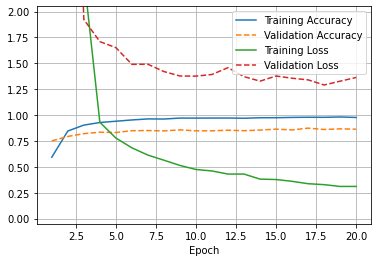

In [27]:
lossAll = np.load('history_loss.npy')
accAll = np.load('history_accuracy.npy')
iouAll = np.load('history_iou.npy')

plt.clf()
plt.xlabel("Epoch")

epochs = range(1, len(lossAll)+1)

plt.plot(epochs, accAll[:,0]/100., ls='-', label='Training Accuracy')
plt.plot(epochs, accAll[:,1]/100., ls='--', label='Validation Accuracy')

plt.plot(epochs, lossAll[:,0], ls='-', label='Training Loss')
plt.plot(epochs, lossAll[:,1], ls='--', label='Validation Loss')

plt.grid(True)
plt.ylim(-0.05,2.05)
plt.legend()
plt.show()

In [21]:
model.load_state_dict(torch.load('model_tsc.pt'))
ccTest, ctTest, lossTest, accTest, iouTest = compNetPars(model, loaderTest, noClasses)

In [22]:
# We note that there are a few classes which are not represented in the test dataset
for i in range(noClasses):
    if i == 0:
        print('Class \tClass frequency in training data \tAccuracy')
    if ctTest[i] > 0:
        print('{:.0f} \t{:.2f}% \t\t\t\t\t{:.2f}% ({:.0f}/{:.0f})'.format(
            i, 100 * classFrequencies[i] / classFrequencies.sum(),
            100 * ccTest[i] / ctTest[i], np.sum(ccTest[i]), np.sum(ctTest[i])))
    else:
        print('{:.0f} \t{:.2f}% \t\t\t\t\tN/A(0/0)'.format(
            i, 100 * classFrequencies[i] / classFrequencies.sum()))
    
print('\nTest Accuracy (Overall): {:.2f}% ({:.0f}/{:.0f})'.format(
        accTest, np.sum(ccTest), np.sum(ctTest)))

Class 	Class frequency in training data 	Accuracy
0 	0.33% 					0.00% (0/5)
1 	2.40% 					100.00% (12/12)
2 	0.28% 					0.00% (0/5)
3 	0.33% 					100.00% (2/2)
4 	0.33% 					16.67% (1/6)
5 	0.24% 					0.00% (0/1)
6 	0.39% 					33.33% (1/3)
7 	3.42% 					79.17% (38/48)
8 	0.59% 					75.00% (3/4)
9 	0.39% 					N/A(0/0)
10 	0.46% 					60.00% (6/10)
11 	0.15% 					N/A(0/0)
12 	0.39% 					100.00% (1/1)
13 	1.96% 					88.89% (16/18)
14 	0.94% 					50.00% (3/6)
15 	0.20% 					N/A(0/0)
16 	0.20% 					0.00% (0/5)
17 	1.72% 					89.06% (57/64)
18 	1.76% 					86.27% (44/51)
19 	5.03% 					97.33% (73/75)
20 	0.91% 					100.00% (1/1)
21 	0.94% 					90.48% (19/21)
22 	8.17% 					100.00% (27/27)
23 	0.33% 					88.89% (8/9)
24 	1.05% 					66.67% (4/6)
25 	0.91% 					100.00% (2/2)
26 	0.13% 					N/A(0/0)
27 	0.39% 					83.33% (5/6)
28 	2.72% 					100.00% (20/20)
29 	0.72% 					63.64% (7/11)
30 	0.81% 					78.57% (11/14)
31 	1.37% 					86.11% (31/36)
32 	6.88% 					99.43% (175/176)
33 	0.26% 					N/A(0/

### Visualize test results

In [23]:
def makePrediction(model, img):
    sm = nn.Softmax(dim=1)
    img = img.to(device)
    
    img = img.unsqueeze(0) # Add extra dimention because the input are single images
    outClass, outBbox, _ = model(img)
    _, pred = torch.max(outClass, 1)    
    prob = sm(outClass)[0][pred]*100.
    
    outBbox = outBbox.detach().cpu().numpy()
    outBbox = outBbox.astype(int)[0]
                        
    return [pred.item(), prob.item(), outBbox]   

In [24]:
results = []
for idx in range(len(dataTest)):
    labelClass = dataTest[idx][1]
    pred, prob, predBox = makePrediction(model, dataTest[idx][0])
    results.append([labelClass, pred, prob, predBox])

In [25]:
def showPredictions(dataset, results):
    plt.clf()
    plt.figure(figsize=(15,15))
    
    # Find indices where predictions match labels and where they do not
    posIndex = [index for index, (l,p,_,_) in enumerate(results) if l == p]
    negIndex = [index for index, (l,p,_,_) in enumerate(results) if l != p]
    # Plot 5 correctly classified examples and 5 incorrect classified.
    idxs = random.sample(posIndex, 5) + random.sample(negIndex, 5)

    for i, idx in zip(range(1,11), idxs):
        plt.subplot(5,5,i)
        img, _, bbox  = dataset[idx]
        label, pred, prob, pbbox = results[idx]
        #print(bbox)
        bpatch = extract_bpatch(bbox)
        pbpatch = extract_bpatch(pbbox, color='red', ls='--')
        imshow(img)
        plt.gca().add_patch(bpatch)
        plt.gca().add_patch(pbpatch)
        plt.title("Label: {:.0f}\nPrediction: {:.0f}({:.2f}%)".format(label, pred, prob),
                  color=("green" if pred==label else "red"))
        plt.axis('off')
    
    plt.tight_layout()

Green solid box: Ground truth

Red dashed box: Prediction

<Figure size 432x288 with 0 Axes>

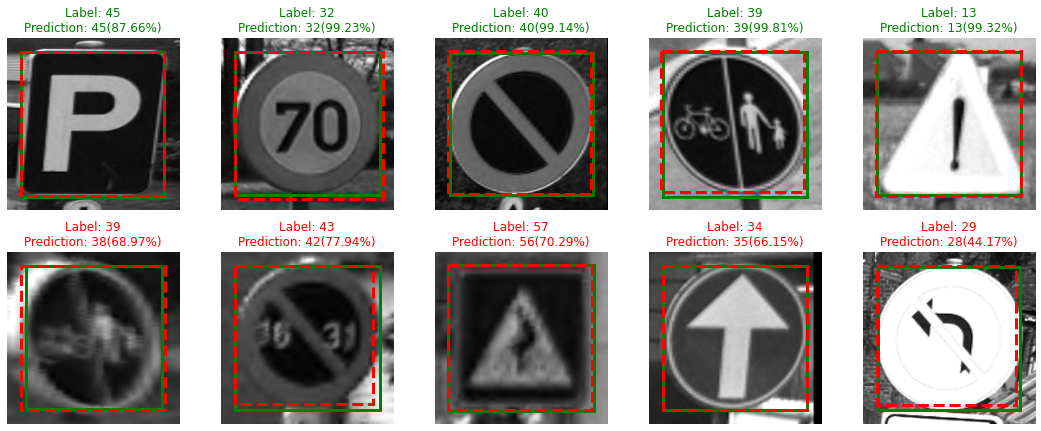

In [26]:
showPredictions(dataTest, results)

In [37]:
print('Weight parameter which scales loss function: {:.2f}'.format(list(model.parameters())[0].item()))

Weight parameter which scales loss function: 100.60


### Discussion

The average Intersection-over-Union of the bounding-box regression is larger than 95%. However, the overall performance is a trade-off between the bounding-box regression and the classification, which has an average accuracy of 86.7%.
This might be adjusted by fixing the weight parameter between the two loss functions. In this example, it is a free model parameter but it stays very close to the initialized value.

One of the main challenges is that most of the classes have too few images. There are, for example, classes missing completely in the validation dataset. This affects the overall predictability of the model but can be addressed using data augmentation techniques as discussed above.